### Repeating Steps 1-8 for LSGAN but for less number of epochs due to time and resource constraints

In [1]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /private/var/folders/v3/fxw_59z942n7bj2rkssnzlv80000gn/T/pip-req-build-09oeif97
  Running command git clone -q https://github.com/tensorflow/docs /private/var/folders/v3/fxw_59z942n7bj2rkssnzlv80000gn/T/pip-req-build-09oeif97
  Resolved https://github.com/tensorflow/docs to commit 86d65616cd1162ee389c8b1e320864d9fa0a82a3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180143 sha256=fa815f0e84ec268bdd352a42bf72160e73b5a9e32e8402456e422e9db8171e08
  Stored in directory: /private/var/folders/v3/fxw_59z942n7bj2rkssnzlv80000gn/T/pip-ephem-wheel-cache-texvqjqu/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [2]:
# loading the mnist dataset
from tensorflow.keras.datasets.fashion_mnist import load_data

(trainX, trainy), (testX, testy) = load_data()
 
# Displaying the shape of the dataset
print('Train Data:', trainX.shape, trainy.shape)
print('Test Data:', testX.shape, testy.shape)

/Users/shounak/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train Data: (60000, 28, 28) (60000,)
Test Data: (10000, 28, 28) (10000,)


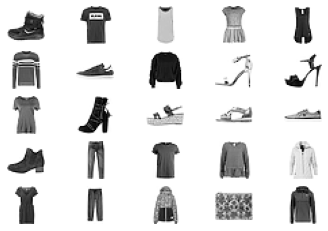

In [3]:
#plotting images from the MNIST training dataset
 
from tensorflow.keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
(trainX, trainy), (testX, testy) = load_data()
for i in range(25):
  # defining subplot
  pyplot.subplot(5, 5, 1 + i)
  # turning off axis
  pyplot.axis('off')
  # plotting raw pixel data
  pyplot.imshow(trainX[i], cmap='Greys')
pyplot.show()


MNIST dataset to train the generator and the discriminator. The generator will generate Unique handwritten digits resembling the MNIST data.

In [4]:
# importing required libraries and functions
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
 
from IPython import display

In [5]:
#setting the training space
(train_img, train_label), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
train_img = train_img.reshape(train_img.shape[0], 28, 28, 1).astype('float32')
train_img = (train_img - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [7]:
#setting the buffer and batch size
buff_size = 60000
batch_size = 256

In [8]:
# Batch and shuffle the data
train_data = tf.data.Dataset.from_tensor_slices(train_img).shuffle(buff_size).batch(batch_size)

The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a random noise.

In [9]:
# defining the generator model
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  # Note: None is the batch size
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   # upsample to 14x14
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    # upsample to 28x28
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

Use the (as yet untrained) generator to create an image.

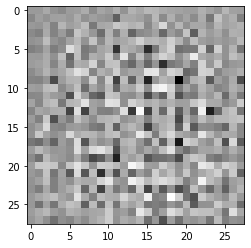

In [10]:
# sample image generated by the generator
genG = genG_model()
 
noise = tf.random.normal([1, 100]) #latent space
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


The Discriminator

The discriminator is a CNN-based image classifier.

In [11]:
# defining the discriminator model
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) #2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) #downsampling  2×2 stride to downsample
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD


Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images

In [12]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)


tf.Tensor([[0.50046015]], shape=(1, 1), dtype=float32)



Define the loss and optimizers

In [13]:
# Computing loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse_loss = tf.keras.losses.MeanSquaredError()

Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [14]:
def discriM_loss(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def genG_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers.

In [16]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                 discriM_optimizer=discriM_optimizer,
                                 genG=genG,
                                 discriM=discriM)


Define the training loop

In [18]:
#defining the number of epochs to train for
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16
 
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [19]:
def trn_img(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [28]:
def train(dataset, epochs):
  j=0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 1 epochs
    if (epoch + 1) % 1 == 0:
      discriM.save('CheckPoint/LSGAN/Dis%d'%j)
      genG.save('CheckPoint/LSGAN/Gen%d'%j)
      j = j+1
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

Generate and save images

In [29]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

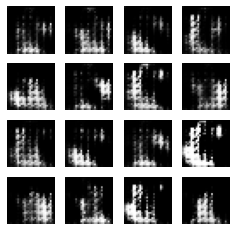

In [30]:
train(train_data, EPOCHS)

In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

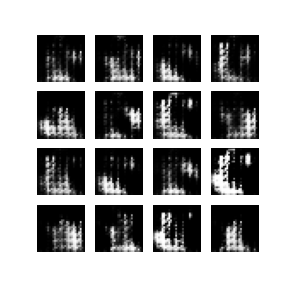

In [33]:
display_image(EPOCHS)

In [34]:
from tensorflow.keras.models import load_model

sgmodel = load_model('CheckPoint/LSGAN/Gen1')
sdmodel = load_model('CheckPoint/LSGAN/Dis1')
sgmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [35]:
def trn_img(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = sgmodel(noise, training=True)

      real_output = sdmodel(images, training=True)
      fake_output = sdmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, sgmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, sdmodel.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, sgmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, sdmodel.trainable_variables))

In [36]:
def train(dataset, epochs):
  j = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images as you go
    display.clear_output(wait=True)
    sv_img(sgmodel,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(sgmodel,
                           epochs,
                           seed)

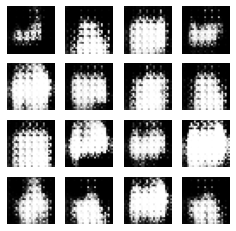

In [37]:
train(train_data, 1)

Since the LSGAN couldn't be run for equal number of epochs (40) it performs worse than GAN, but if it was repeated with higher processing resources, LSGAN should have resulted in better results with same number of epochs. This is because of the loss function of LSGAN is much more optimised than GAN